# Word2Vec Using Genism 
    Data - A song of ice and fire (book 1 and 2)

In [1]:
import codecs
import glob
import multiprocessing
import os
import pprint
import re
import nltk
import gensim.models.word2vec as w2v
import sklearn.manifold
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


Using TensorFlow backend.


In [2]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/payas/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/payas/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [84]:
book_filenames = sorted(glob.glob("../data/GOT_books/*.txt"))


In [85]:
corpus_raw = u""

for book_filename in book_filenames:

    with codecs.open(book_filename,"r","utf-8",errors='ignore') as book_file:
            corpus_raw += book_file.read()
    print(len(corpus_raw))

1628063
3436003


In [86]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
raw_sentences = tokenizer.tokenize(corpus_raw)

In [87]:
def sentence_to_wordlist(raw):
    clean = re.sub("[^a-zA-Z]"," ",raw)
    words = clean.split()
    return words


In [88]:
sentences = []
for raw_sentence in raw_sentences:
    if len(raw_sentence) > 0:
        sentences.append(sentence_to_wordlist(raw_sentence))

In [89]:
sentences

[['A',
  'Game',
  'Of',
  'Thrones',
  'Book',
  'One',
  'of',
  'A',
  'Song',
  'of',
  'Ice',
  'and',
  'Fire',
  'By',
  'George',
  'R',
  'R',
  'Martin',
  'PROLOGUE',
  'We',
  'should',
  'start',
  'back',
  'Gared',
  'urged',
  'as',
  'the',
  'woods',
  'began',
  'to',
  'grow',
  'dark',
  'around',
  'them'],
 ['The', 'wildlings', 'are', 'dead'],
 ['Do', 'the', 'dead', 'frighten', 'you'],
 ['Ser',
  'Waymar',
  'Royce',
  'asked',
  'with',
  'just',
  'the',
  'hint',
  'of',
  'a',
  'smile'],
 ['Gared', 'did', 'not', 'rise', 'to', 'the', 'bait'],
 ['He',
  'was',
  'an',
  'old',
  'man',
  'past',
  'fifty',
  'and',
  'he',
  'had',
  'seen',
  'the',
  'lordlings',
  'come',
  'and',
  'go'],
 ['Dead', 'is', 'dead', 'he', 'said'],
 ['We', 'have', 'no', 'business', 'with', 'the', 'dead'],
 ['Are', 'they', 'dead'],
 ['Royce', 'asked', 'softly'],
 ['What', 'proof', 'have', 'we'],
 ['Will', 'saw', 'them', 'Gared', 'said'],
 ['If',
  'he',
  'says',
  'they',
  'ar

In [91]:
num_features = 100
min_word_count  = 3
num_workers = multiprocessing.cpu_count()
context_size = 2
downsampling = 1e-3
seed =1

In [92]:
thrones2vec = w2v.Word2Vec(
    sg=1,
    seed=seed,
    
    workers=num_workers,
    size=num_features,
    min_count=min_word_count,
    window=context_size,
    sample=downsampling
)

In [93]:
thrones2vec.build_vocab(sentences)




In [94]:
thrones2vec.train(sentences,epochs = thrones2vec.iter,
    total_examples=thrones2vec.corpus_count)
thrones2vec.save(os.path.join("/home/payas/dl_box/data/GOT_books/trained", "thrones2vec.w2v"))

In [95]:
thrones2vec = w2v.Word2Vec.load(os.path.join("/home/payas/dl_box/data/GOT_books/trained", "thrones2vec.w2v"))


In [96]:
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)
all_word_vectors_matrix = thrones2vec.wv.syn0 
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/payas/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['seed']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [97]:
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[thrones2vec.wv.vocab[word].index])
            for word in thrones2vec.wv.vocab
        ]
    ],
    columns=["word", "x", "y"]
)

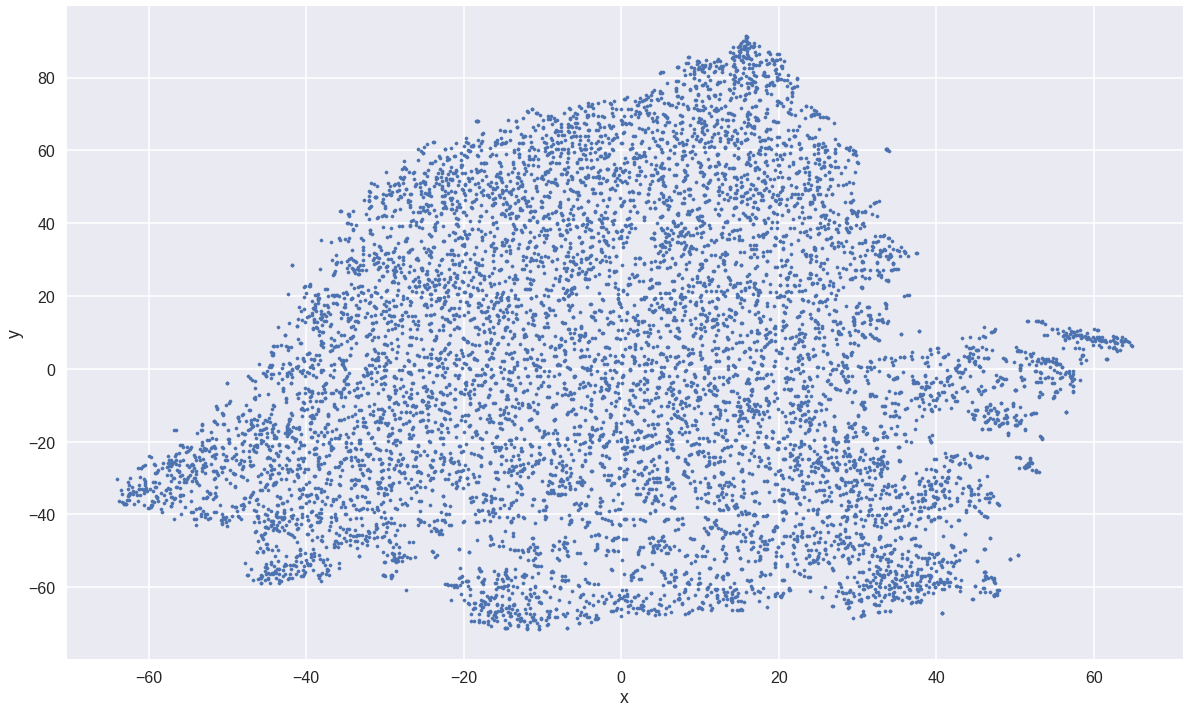

In [98]:

sns.set_context("poster")
points.plot.scatter("x", "y", s=10, figsize=(20, 12))

In [99]:

def plot_region(x_bounds, y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) & 
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter("x", "y", s=35, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

In [103]:
thrones2vec.most_similar("Stark")


[('Lysa', 0.8336511850357056),
 ('Eddard', 0.8111896514892578),
 ('Arryn', 0.8099024891853333),
 ('Benjen', 0.807231068611145),
 ('Ben', 0.798617959022522),
 ('Brandon', 0.797805666923523),
 ('Petyr', 0.7923687696456909),
 ('Tanda', 0.79073166847229),
 ('Baelish', 0.7898837327957153),
 ('Hornwood', 0.7886515855789185)]

In [104]:
# #distance, similarity, and ranking
def nearest_similarity_cosmul(start1, end1, end2):
    similarities = thrones2vec.most_similar_cosmul(
        positive=[end2, start1],
        negative=[end1]
    )
    start2 = similarities[0][0]
    print("{start1} is related to {end1}, as {start2} is related to {end2}".format(**locals()))
    return start2

In [107]:
#print(sentences)
nearest_similarity_cosmul("queen", "woman", "man")
nearest_similarity_cosmul("Jaime", "sword", "crown")

queen is related to woman, as king is related to man
Jaime is related to sword, as Tywin is related to crown


'Tywin'